![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/jupyter/Cards/SparkOcrImageTableDetection.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

In [1]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Saving spark-license-v410.json to spark-license-v410.json


In [2]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.0 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

     |████████████████████████████████| 281.3 MB 49 kB/s 
     |████████████████████████████████| 616 kB 62.8 MB/s 
     |████████████████████████████████| 198 kB 46.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.1.0-52f8e0a3b8cf4b1b63c864d38b2851b1f5484f25
     |████████████████████████████████| 30.8 MB 1.1 MB/s 
     |████████████████████████████████| 281.4 MB 47 kB/s 
     |████████████████████████████████| 200 kB 68.2 MB/s 
     |████████████████████████████████| 30.2 MB 1.2 MB/s 
     |████████████████████████████████| 4.3 MB 46.1 MB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
     |████████████████████████████████| 198 kB 60.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853643 sha256=9f355786270ac0a8fa44f8cc55616111ccaa06d26060c93796cb71ad2b71013f
  Stored in directory: /root/.cache/pip/wheels/58/94/83/915c9059e4b038e2d43a6058f30

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [3]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 4.1.0
Spark OCR version: 4.1.0



## Read images and display it

In [4]:
!wget -q https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/4.0.0-release-candidate/jupyter/data/tab_images/cTDaR_t10168.jpg


    Image #0:
    Origin: file:/content/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


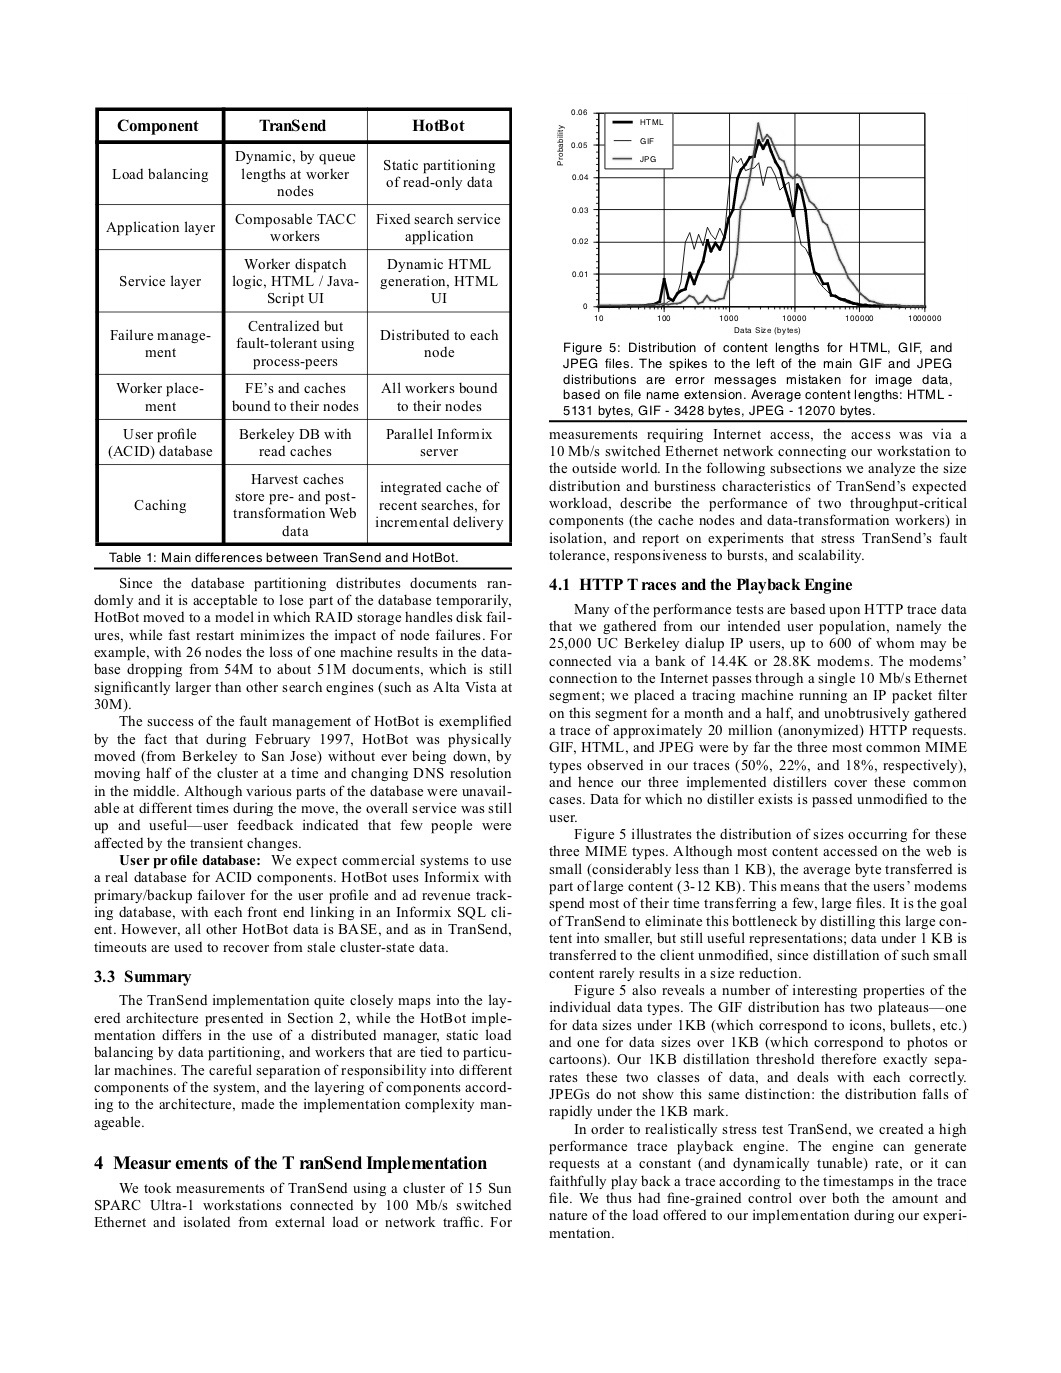

In [5]:
imagePath = "cTDaR_t10168.jpg"
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [6]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("table_regions")

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("table_regions")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/content/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


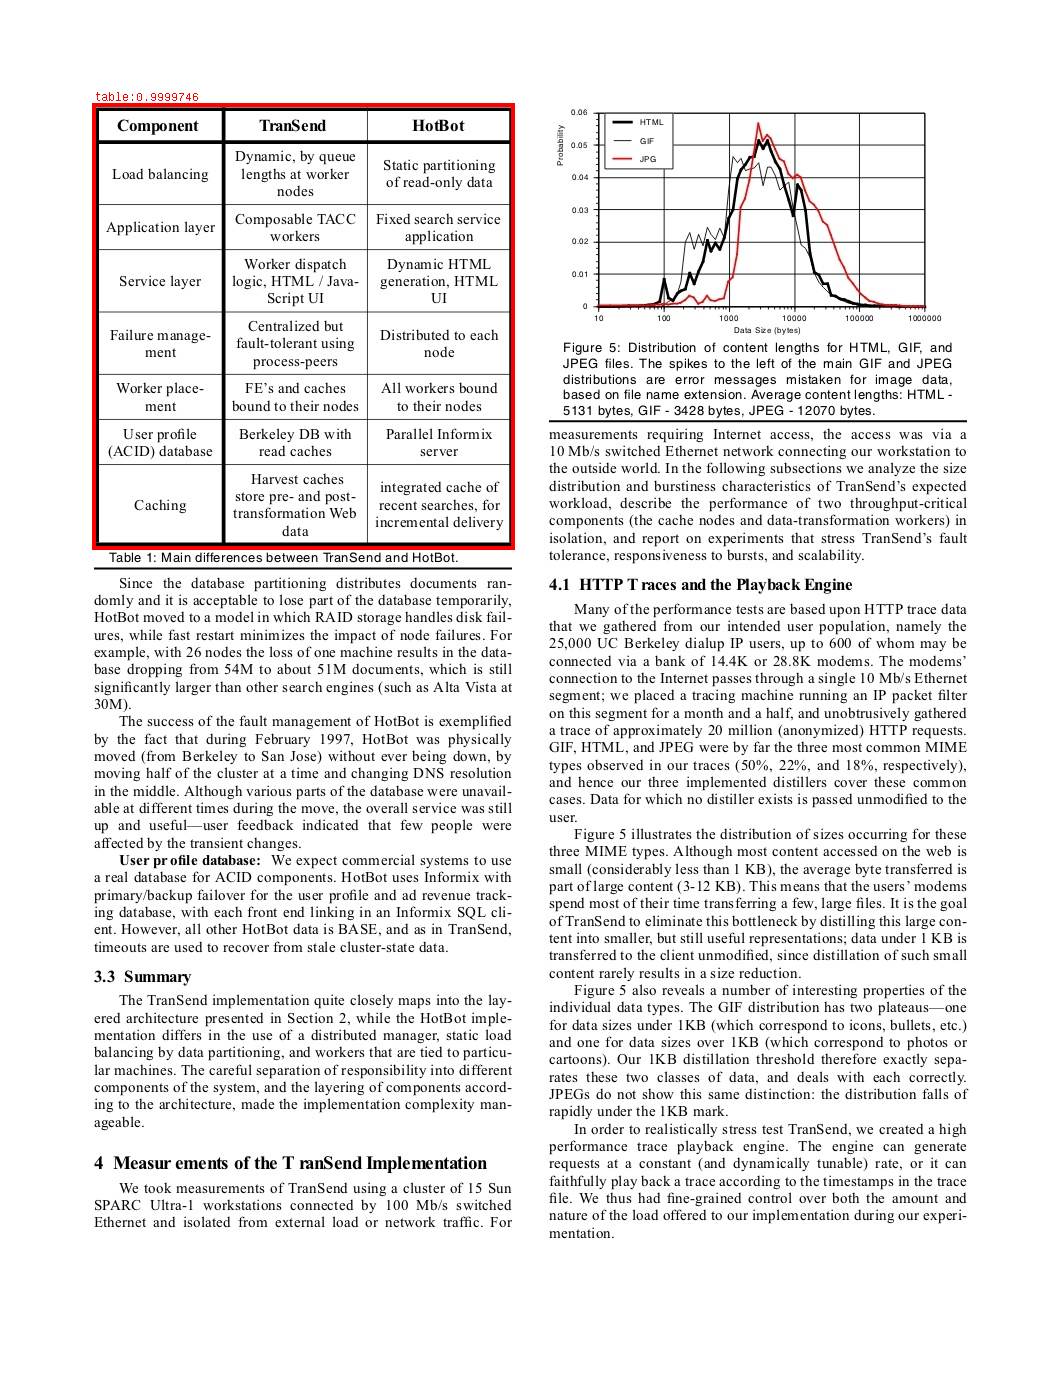

In [7]:
result = pipeline.transform(image_df)
display_images(result, "image_with_regions")

In [8]:
spark.stop()